# Curve based bundle pricing

We assess the possibility of pricing bundles through the use of a parametric curve of gas price vs position in block. We evaluate how different curves with varying amount of parameters fit the actual block data.

## Preliminary setup

In [224]:
from web3 import Web3
import numpy as np
import json
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from dotenv import dotenv_values, load_dotenv

In [245]:
config = dotenv_values()
w3 = Web3(Web3.HTTPProvider(config["ETHEREUM_RPC_URL"]))
w3.isConnected(), w3.eth.block_number

(True, 12232890)

## Get gas data and save to file (no need to run if already stored)

In [62]:
# Define constants -- 10 blocks
BLOCK_GAP = 10000
BLOCK_STEP = 1000
INITIAL_BLOCK = 12227385

In [63]:
raw_gas = {} 
for block_number in range(INITIAL_BLOCK, INITIAL_BLOCK-BLOCK_GAP, -BLOCK_STEP):
    raw_gas[block_number] = []
    txs = w3.eth.get_block(block_number)['transactions']
    for tx in txs:
        raw_gas[block_number].append((w3.eth.get_transaction_receipt(tx)['gasUsed'],w3.eth.get_transaction(tx)['gasPrice']))

In [64]:
with open('../data/raw_gas.json', 'w') as file:
    json.dump(raw_gas, file)

## Read data from file (no need to run if generated in this pass)

In [3]:
with open('../data/raw_gas.json', 'r') as file:
    raw_gas = json.load(file)

In [8]:
#test
raw_gas['12227385'][0]

[61256, 0]

## Data visualization

We are going to look at transaction gas price as a function of its position in the block

In [15]:
# Setup data
gas_usage = {}
gas_prices = {}
block_positions = {}
for k,v in raw_gas.items():
    block_data_array = np.array(v)
    gas_usage[k] = np.array(block_data_array)[:,0]
    gas_prices[k] = np.array(block_data_array)[:,1]/1e9
    block_positions[k] = np.cumsum(block_data_array[:,0])/np.sum(block_data_array[:,0])

Raw plots

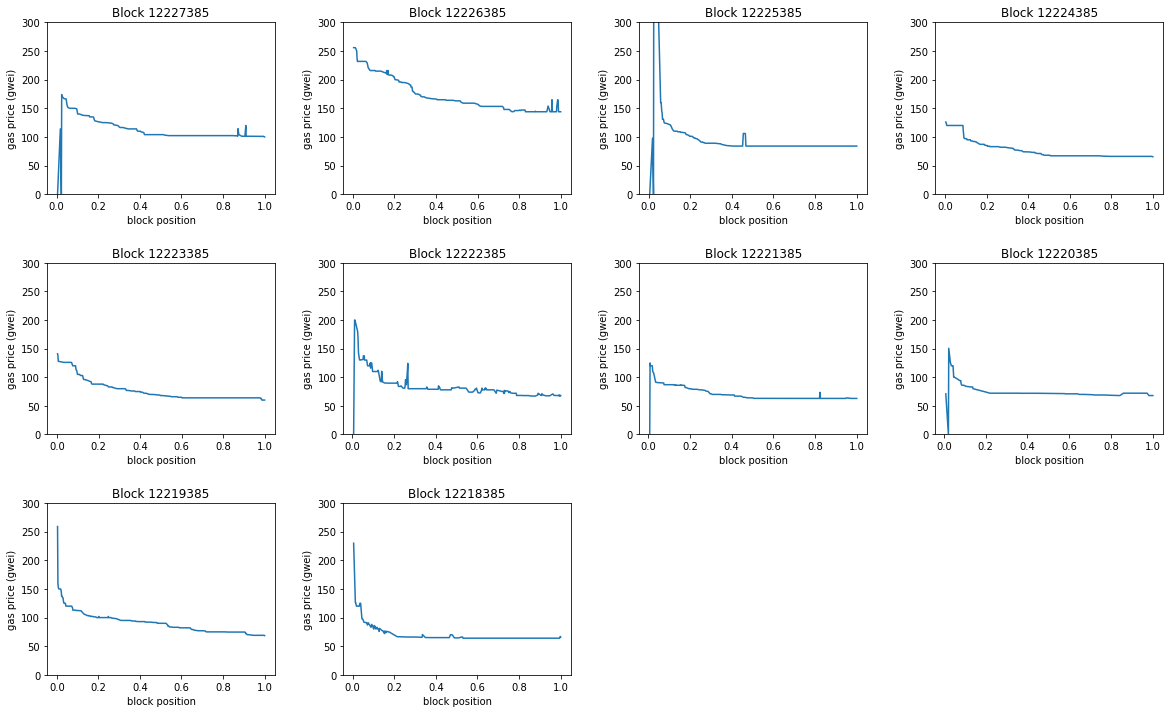

In [104]:
# Plot linear scale, truncating to fixed gas range to appreciate variability
plt.figure(figsize=(20, 12))
plt.subplots_adjust(hspace=0.4, wspace=0.3)
ylims = (0, 300)
for i, block in enumerate(raw_gas.keys()):
    axes = plt.subplot(3, 4, i+1)
    axes.plot(block_positions[block], gas_prices[block])
    axes.set_ylim(ylims)
    axes.set_title("Block "+block)
    axes.set_xlabel("block position")
    axes.set_ylabel("gas price (gwei)")

Semi-log to check exponential dependence

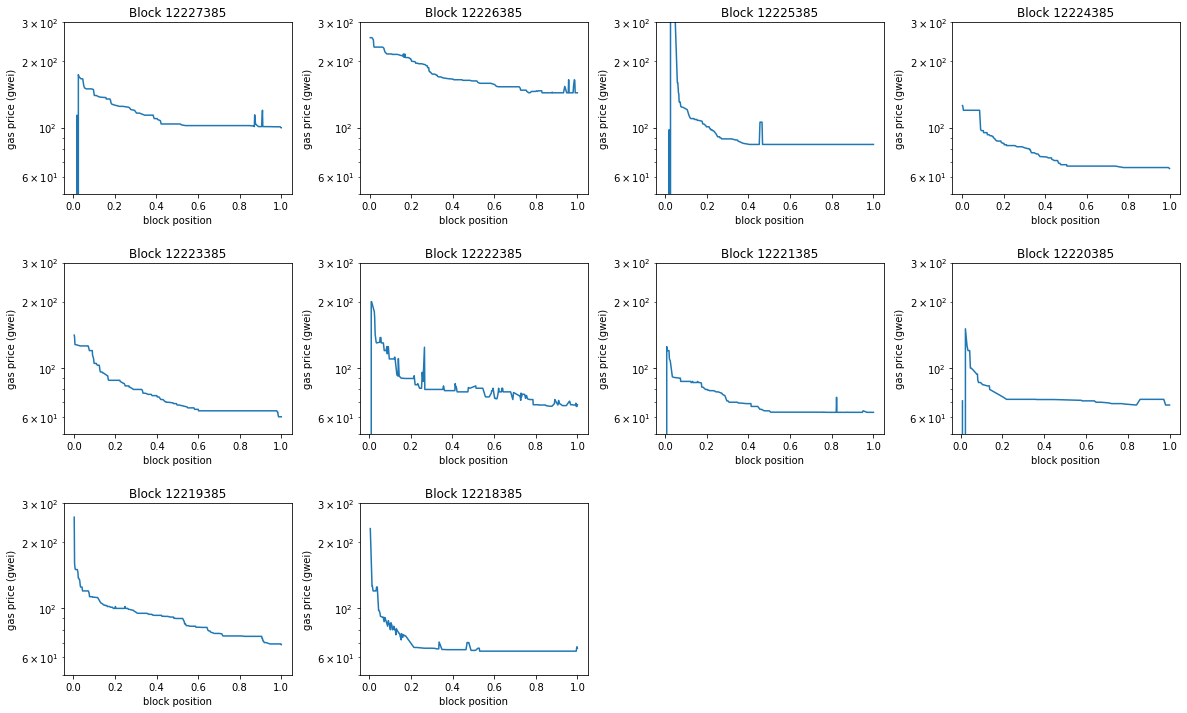

In [105]:
# Plot semi-log scale
plt.figure(figsize=(20, 12))
plt.subplots_adjust(hspace=0.4, wspace=0.3)
ylims = (50, 300)
for i, block in enumerate(raw_gas.keys()):
    axes = plt.subplot(3, 4, i+1)
    axes.plot(block_positions[block], gas_prices[block])
    axes.set_ylim(ylims)
    axes.set_title(block)
    axes.set_yscale('log')
    axes.set_title("Block "+block)
    axes.set_xlabel("block position")
    axes.set_ylabel("gas price (gwei)")

This doesn't look super linear, perhaps piecewise with a kink.

Log-log plots to test power law

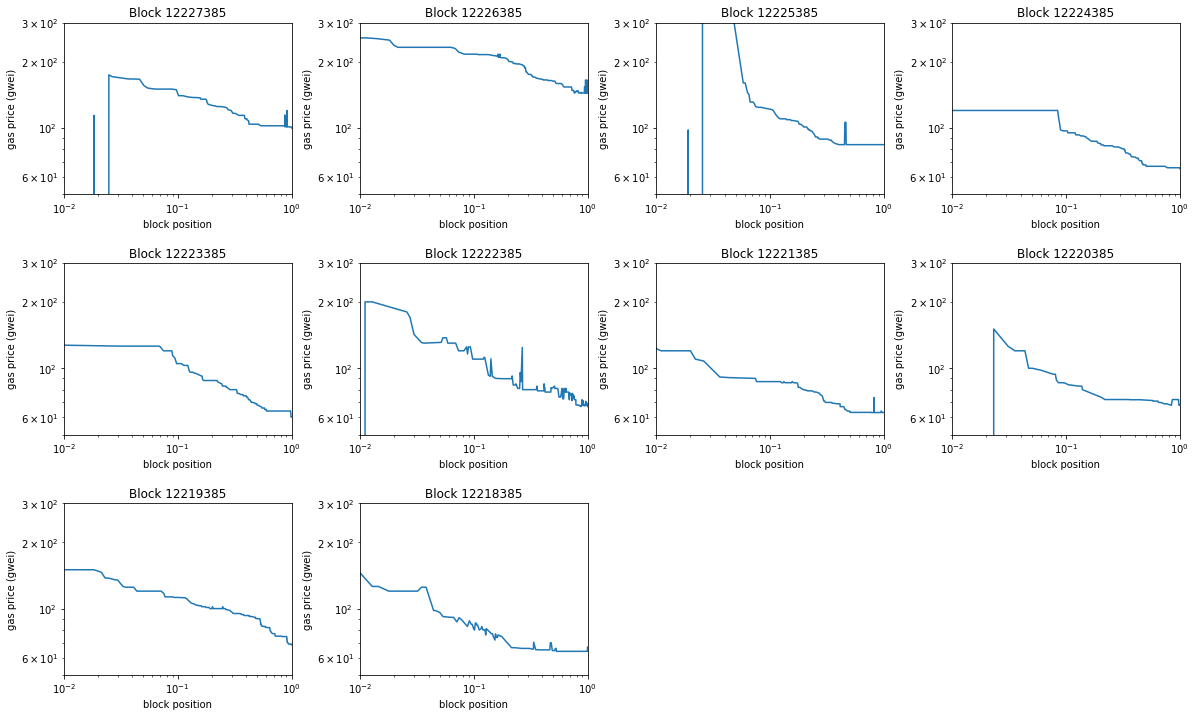

In [106]:
# Plot log-log scale
plt.figure(figsize=(20, 12))
plt.subplots_adjust(hspace=0.4, wspace=0.3)
xlims = (0.01, 1)
ylims = (50, 300)
for i, block in enumerate(raw_gas.keys()):
    axes = plt.subplot(3, 4, i+1)
    axes.plot(block_positions[block], gas_prices[block])
    axes.set_ylim(ylims)
    axes.set_xlim(xlims)
    axes.set_title(block)
    axes.set_yscale('log')    
    axes.set_xscale('log')
    axes.set_title("Block "+block)
    axes.set_xlabel("block position")
    axes.set_ylabel("gas price (gwei)")

Looks like power law should be a reasonable fit, apart from some weirdness in the block start (note several Flashbots blocks in the sample!)

## Fit

### 2 parameter version

Use a power law function $g(x)=A.x^{-k}$ with two free parameters, gas price at block head and gas price at block tail. The block head actually "moves", since it's at the gas used by the first transaction. To further complicate matters, we have many Flashbots blocks with ~3 txs at irregular prices. We'll use the fourth transaction, first finding its average position to hardcode into the function.

In [111]:
block_position_at_3 = []
for block in raw_gas.keys():
    block_position_at_3.append(block_positions[block][3])
np.mean(block_position_at_3)

0.02032163502976998

In [112]:
def gas(x, g_at3, gt):
    return gt*x**(np.log(g_at3/gt)/np.log(0.0203))

# test mid block
gas(0.5, 300, 100)

121.57971925358657

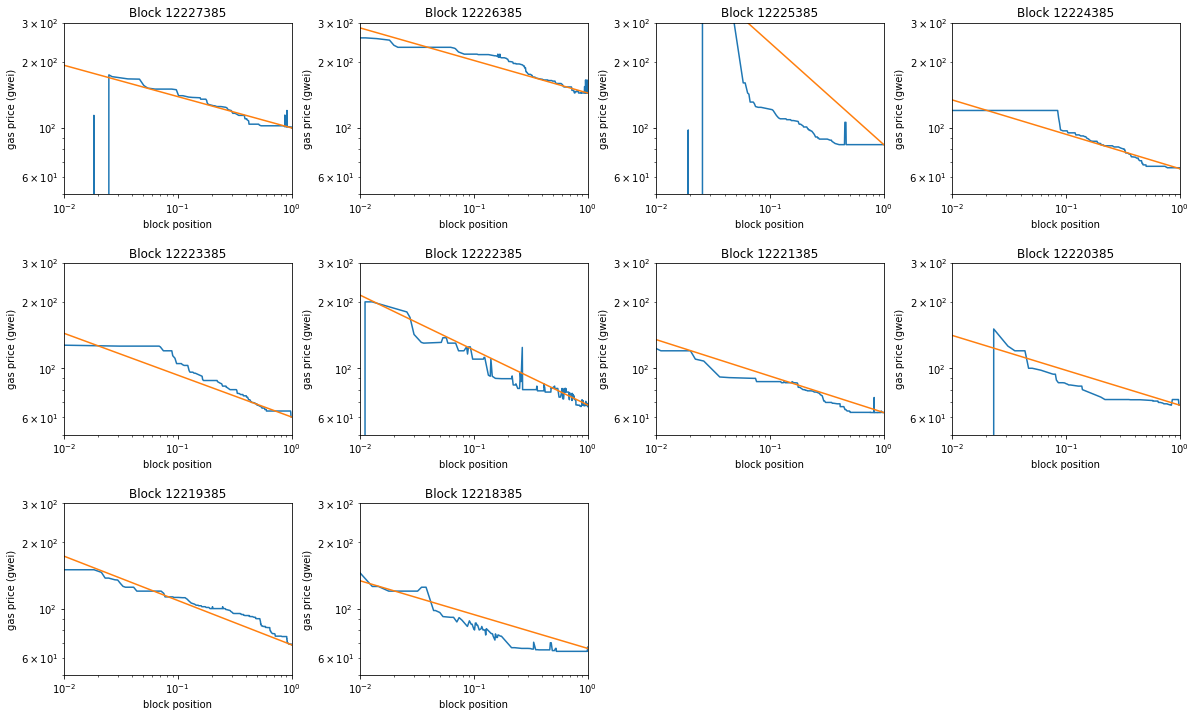

In [113]:
# Plot log-log scale
plt.figure(figsize=(20, 12))
plt.subplots_adjust(hspace=0.4, wspace=0.3)
xlims = (0.01, 1)
ylims = (50, 300)
for i, block in enumerate(raw_gas.keys()):
    axes = plt.subplot(3, 4, i+1)
    axes.plot(block_positions[block], gas_prices[block])
    axes.plot(block_positions[block], gas(block_positions[block], gas_prices[block][3], gas_prices[block][-1]))
    axes.set_ylim(ylims)
    axes.set_xlim(xlims)
    axes.set_yscale('log')    
    axes.set_xscale('log')
    axes.set_title("Block "+block)
    axes.set_xlabel("block position")
    axes.set_ylabel("gas price (gwei)")

This looks reasonable, but we still incur an unnecessary error by hardcoding the position parameter. We can actually pick it up from data.

### 3 parameter version

This version allows for passing in the gas price at any chosen position as opposed to fixing one a priori as before. It is redundant in the sense that it could be obtained from the previous one if the interpolation was carried out outside of the function (or is more precise if no adjustment is done).

In [114]:
def gas3(x, gt, gat, at):
    return gt*x**(np.log(gat/gt)/np.log(at))

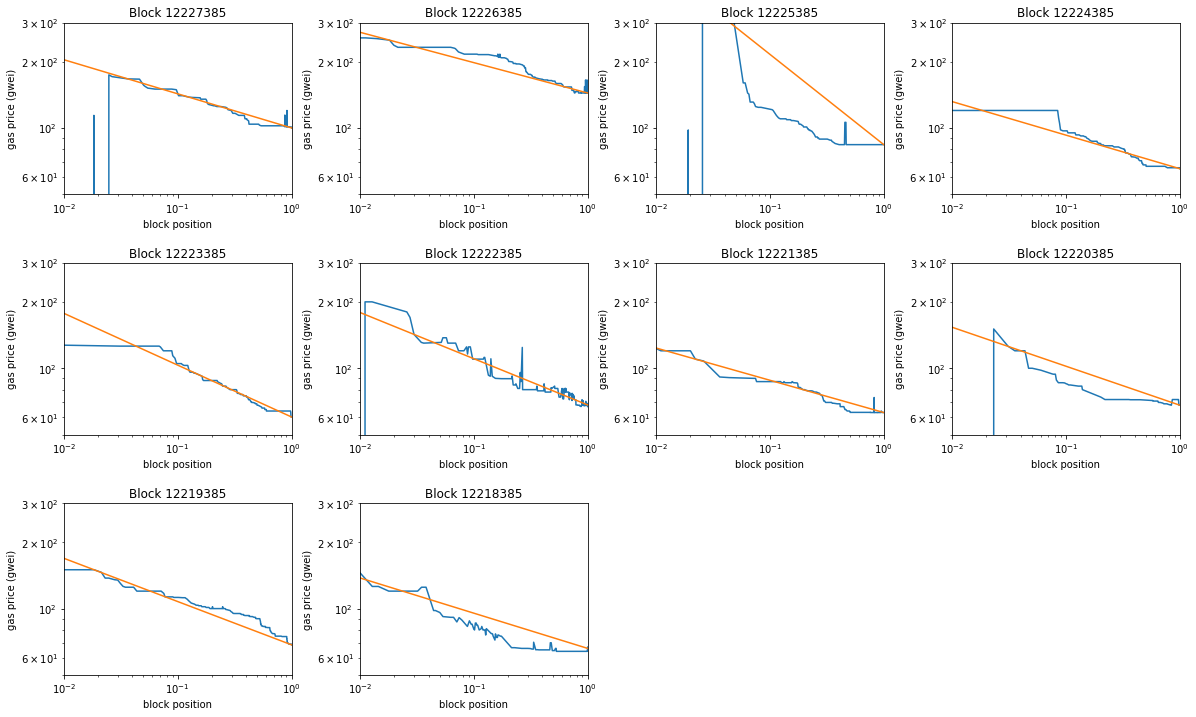

In [154]:
# Plot log-log scale
plt.figure(figsize=(20, 12))
plt.subplots_adjust(hspace=0.4, wspace=0.3)
xlims = (0.01, 1)
ylims = (50, 300)
for i, block in enumerate(raw_gas.keys()):
    axes = plt.subplot(3, 4, i+1)
    axes.plot(block_positions[block], gas_prices[block])
    axes.plot(block_positions[block], gas3(block_positions[block], gas_prices[block][-1], gas_prices[block][5], block_positions[block][5]))
    axes.set_ylim(ylims)
    axes.set_xlim(xlims)
    axes.set_yscale('log')    
    axes.set_xscale('log')
    axes.set_title("Block "+block)
    axes.set_xlabel("block position")
    axes.set_ylabel("gas price (gwei)")

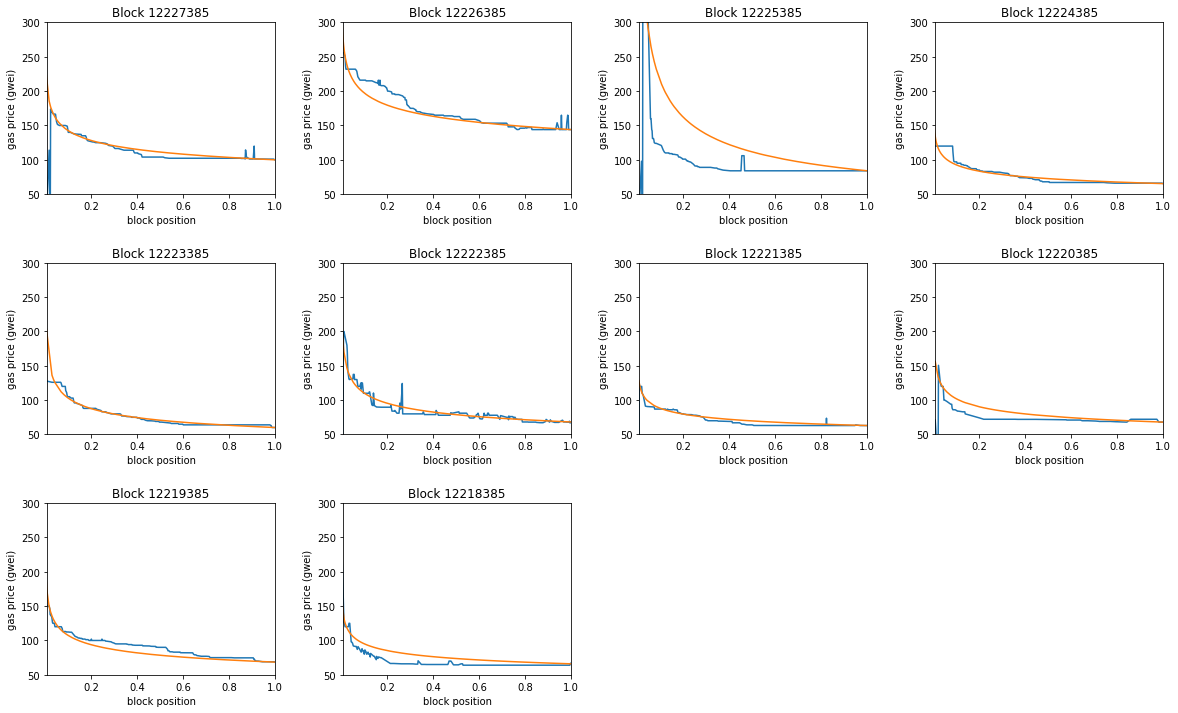

In [155]:
# Plot linear scale
plt.figure(figsize=(20, 12))
plt.subplots_adjust(hspace=0.4, wspace=0.3)
xlims = (0.01, 1)
ylims = (50, 300)
for i, block in enumerate(raw_gas.keys()):
    axes = plt.subplot(3, 4, i+1)
    axes.plot(block_positions[block], gas_prices[block])
    axes.plot(block_positions[block], gas3(block_positions[block], gas_prices[block][-1], gas_prices[block][5], block_positions[block][5]))
    axes.set_ylim(ylims)
    axes.set_xlim(xlims)
    axes.set_title("Block "+block)
    axes.set_xlabel("block position")
    axes.set_ylabel("gas price (gwei)")

Ok, this looks like a sufficient approximation. We still have one hardcoded parameter, here 5, the transaction index we use for calibration, but it doesn't seem to have much impact in the range 3-10.

Note that we're using same-block parameters to do the adjustment, which we won't have at the time of estimation. We need to use data from past (adjacent) block(s). 

## Adjacent block model

Get consecutive-block gas data

In [163]:
# Define constants -- 10 blocks
BLOCK_AMOUNT = 10
INITIAL_BLOCK = 12227385
raw_gas_consecutive = []
for i, block_number in enumerate(range(INITIAL_BLOCK, INITIAL_BLOCK-BLOCK_AMOUNT, -1)):
    txs = w3.eth.get_block(block_number)['transactions']
    raw_gas_consecutive.append([])
    for j,tx in enumerate(txs):
        raw_gas_consecutive[i].append([])
        raw_gas_consecutive[i][j]=(w3.eth.get_transaction_receipt(tx)['gasUsed'],w3.eth.get_transaction(tx)['gasPrice'])

In [141]:
raw_gas_consecutive[0][0]

(61256, 0)

In [164]:
with open('../data/raw_gas_consecutive-' + str(INITIAL_BLOCK) + '.json', 'w') as file:
    json.dump(raw_gas_consecutive, file)

Read data from file (no need to run if generated in this pass)

In [144]:
with open('../data/raw_gas_consecutive-' + str(INITIAL_BLOCK) + '.json', 'r') as file:
    raw_gas_consecutive = json.load(file)
#test
raw_gas_consecutive[0][0]

[61256, 0]

In [165]:
# Setup data
gas_usage_consecutive = []
gas_prices_consecutive = []
block_positions_consecutive = []
for v in raw_gas_consecutive:
    block_data_array = np.array(v)
    gas_usage_consecutive.append(np.array(block_data_array)[:,0])
    gas_prices_consecutive.append(np.array(block_data_array)[:,1]/1e9)
    block_positions_consecutive.append(np.cumsum(block_data_array[:,0])/np.sum(block_data_array[:,0]))

In [166]:
# Same function
def gas3(x, gt, gat, at):
    return gt*x**(np.log(gat/gt)/np.log(at))

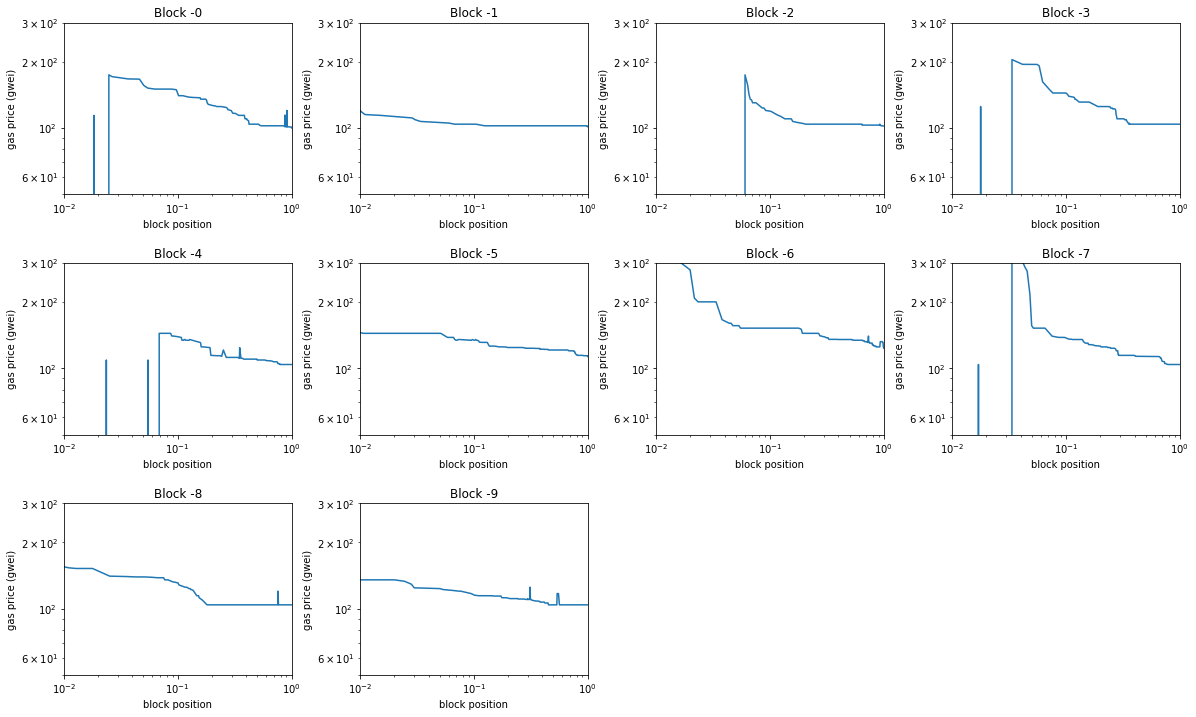

In [167]:
# Visualize data, no fit
plt.figure(figsize=(20, 12))
plt.subplots_adjust(hspace=0.4, wspace=0.3)
xlims = (0.01, 1)
ylims = (50, 300)
for i, data in enumerate(raw_gas_consecutive):
    axes = plt.subplot(3, 4, i+1)
    axes.plot(block_positions_consecutive[i], gas_prices_consecutive[i])
    axes.set_ylim(ylims)
    axes.set_xlim(xlims)
    axes.set_yscale('log')    
    axes.set_xscale('log')
    axes.set_title("Block -"+str(i))
    axes.set_xlabel("block position")
    axes.set_ylabel("gas price (gwei)")

Text(0, 0.5, 'gas price (gwei)')

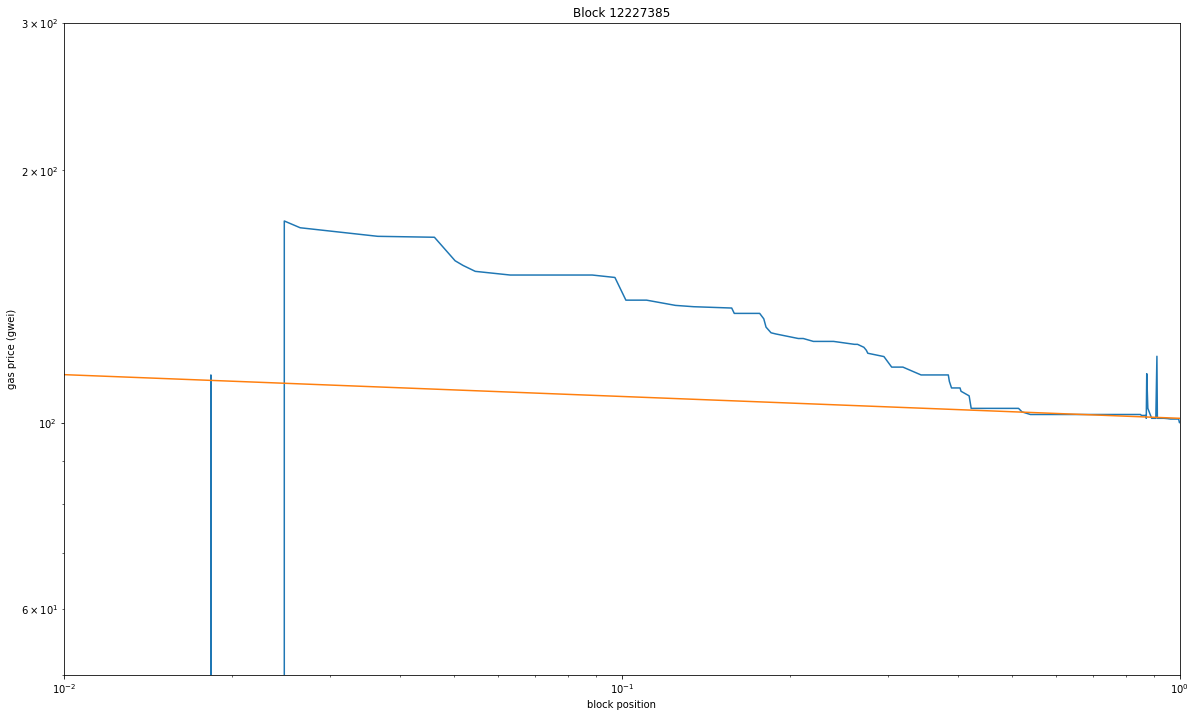

In [209]:
# Single, last block fit
plt.figure(figsize=(20, 12))
plt.subplots_adjust(hspace=0.4, wspace=0.3)
xlims = (0.01, 1)
ylims = (50, 300)
axes = plt.subplot(1, 1, 1)
axes.plot(block_positions_consecutive[0], gas_prices_consecutive[0])
axes.plot(block_positions_consecutive[0], gas3(block_positions_consecutive[0], gas_prices_consecutive[1][-1], gas_prices_consecutive[1][5], block_positions_consecutive[1][5]))
axes.set_ylim(ylims)
axes.set_xlim(xlims)
axes.set_yscale('log')    
axes.set_xscale('log')
axes.set_title("Block "+str(INITIAL_BLOCK))
axes.set_xlabel("block position")
axes.set_ylabel("gas price (gwei)")

Not a very good fit, wild variation between consecutive blocks apparently

In [206]:
# prep data
past_tail_price = []
past_at_price = []
past_at_position = []
for i in range(1, BLOCK_AMOUNT):
    past_tail_price.append(gas_prices_consecutive[i][-1])
    past_at_price.append(gas_prices_consecutive[i][5])
    past_at_position.append(block_positions_consecutive[i][5])
tail_price_mean = np.mean(past_tail_price)
at_price_mean = np.mean(past_at_price)
at_position_mean = np.mean(past_at_position)

In [203]:
at_position_mean

0.035875475720375145

Text(0, 0.5, 'gas price (gwei)')

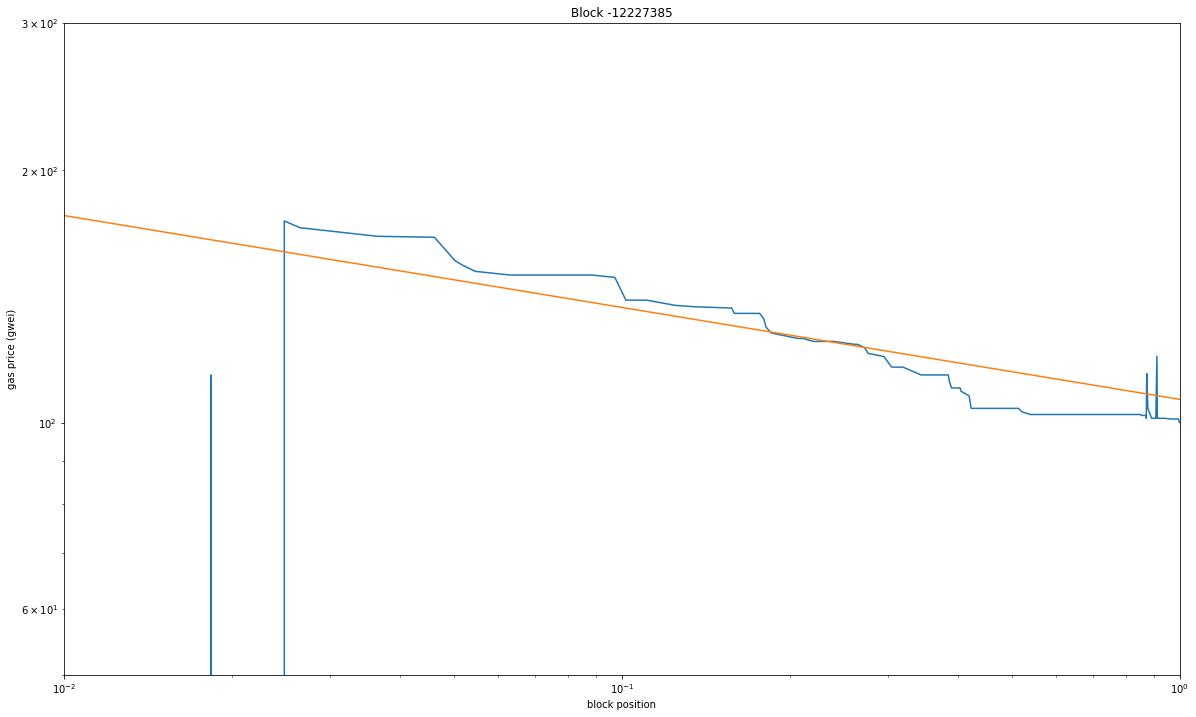

In [210]:
# 10 past blocks fit
plt.figure(figsize=(20, 12))
plt.subplots_adjust(hspace=0.4, wspace=0.3)
xlims = (0.01, 1)
ylims = (50, 300)
axes = plt.subplot(1, 1, 1)
axes.plot(block_positions_consecutive[0], gas_prices_consecutive[0])
axes.plot(block_positions_consecutive[0], gas3(block_positions_consecutive[0], tail_price_mean, at_price_mean, at_position_mean))
axes.set_ylim(ylims)
axes.set_xlim(xlims)
axes.set_yscale('log')    
axes.set_xscale('log')
axes.set_title("Block -"+str(INITIAL_BLOCK))
axes.set_xlabel("block position")
axes.set_ylabel("gas price (gwei)")